In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
x = torch.linspace(0, 799, 800)

In [3]:
y = torch.sin(x * 2 * 3.1414 / 48)

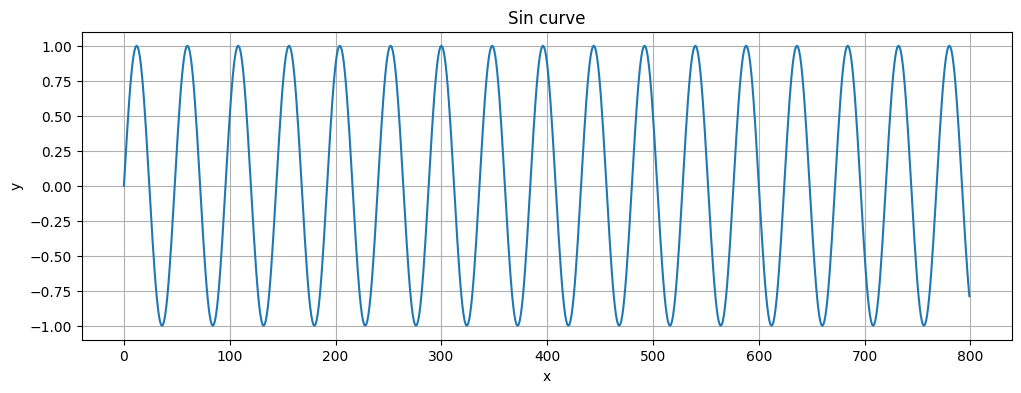

In [4]:
plt.figure(figsize=(12, 4))
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.title("Sin curve")
plt.show()

In [5]:
### Splitting the data in train/test set
test_size = 40
train_set = y[:len(y) - test_size]
test_set = y[len(train_set):]
print(train_set.shape, test_set.shape)

torch.Size([760]) torch.Size([40])


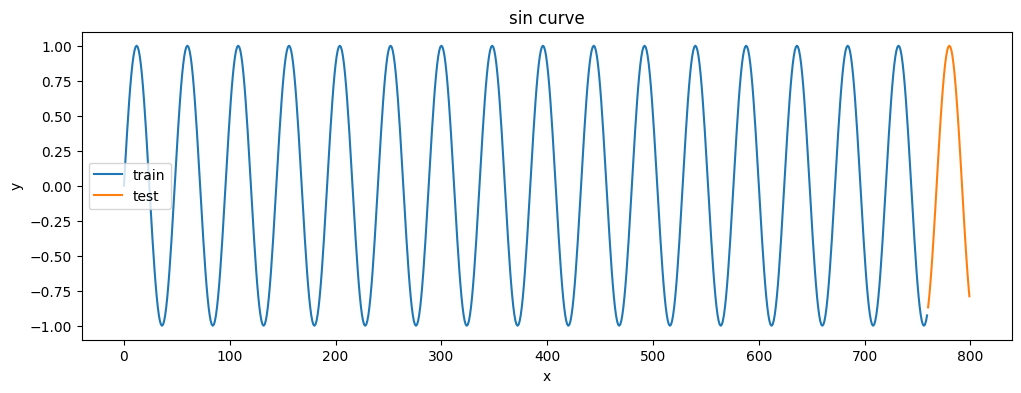

In [6]:
plt.figure(figsize = (12, 4))
plt.xlabel('x')
plt.ylabel('y')
plt.title("sin curve")
plt.plot(np.arange(0, len(train_set)), train_set)
plt.plot(np.arange(len(train_set), len(train_set) + len(test_set)), test_set)
plt.legend(["train", "test"])
plt.show()

#### Creating batches of data
While working with RNN models, we divide the training sequence into series of overlapping windows. The label used for comparison is the next value in the sequence. 
For example if we have series of 12 records and a window size of 3, we feed [x1, x2, x3] into the model and compare the prediction to x4. Then we backprop, update parameters and feed [x2, x3, x4] into the model and compare the prediction to x5. To ease this process, we are going to define a function __input_data(seq, ws)__ that created a list of (seq, labels) tuples. If ws is the window size, then the total number of (seq, labels) tuples will be len(series) - ws

In [7]:
def input_data(seq, ws):
    out = []
    L = len(seq)

    for i in range(L - ws):
        window = seq[i:i + ws]
        label = seq[i + ws: i + ws + 1]
        out.append((window, label))
    
    return out

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../data"))

# Import Libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

['FashionMNIST', 'house_tiny.csv', 'kaggle_house_pred_test.csv', 'kaggle_house_pred_train.csv', 'timemachine.txt']


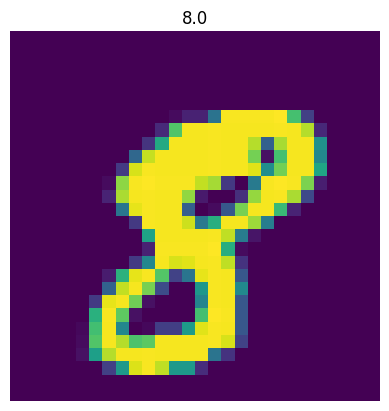

In [11]:
# Prepare Dataset
# load data
train = pd.read_csv(r"../data/train.csv",dtype = np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = TensorDataset(featuresTrain,targetsTrain)
test = TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# visualize one of the images in data set
plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

In [12]:
# Create RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
            
        # One time step
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) 
        return out

# batch_size, epoch and iteration
batch_size = 100
n_iters = 8000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = TensorDataset(featuresTrain,targetsTrain)
test = TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)
    
# Create RNN
input_dim = 28    # input dimension
hidden_dim = 100  # hidden layer dimension
layer_dim = 1     # number of hidden layers
output_dim = 10   # output dimension

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [14]:
seq_dim = 28  
loss_list = []
iteration_list = []
accuracy_list = []
count = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        train  = Variable(images.view(-1, seq_dim, input_dim))
        labels = Variable(labels )
            
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 250 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images = Variable(images.view(-1, seq_dim, input_dim))
                
                # Forward propagation
                outputs = model(images)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += labels.size(0)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.item(), accuracy))

Iteration: 500  Loss: 1.4851840734481812  Accuracy: 51.10714340209961 %
Iteration: 1000  Loss: 0.38855379819869995  Accuracy: 86.29762268066406 %
Iteration: 1500  Loss: 0.28994765877723694  Accuracy: 89.66666412353516 %
Iteration: 2000  Loss: 0.3323906660079956  Accuracy: 90.97618865966797 %
Iteration: 2500  Loss: 0.18973539769649506  Accuracy: 92.5 %
Iteration: 3000  Loss: 0.11244627833366394  Accuracy: 93.78571319580078 %
Iteration: 3500  Loss: 0.28489959239959717  Accuracy: 93.57142639160156 %
Iteration: 4000  Loss: 0.18999053537845612  Accuracy: 94.02381134033203 %
Iteration: 4500  Loss: 0.20152969658374786  Accuracy: 95.13095092773438 %
Iteration: 5000  Loss: 0.08089596778154373  Accuracy: 95.16666412353516 %
Iteration: 5500  Loss: 0.1645708978176117  Accuracy: 95.61904907226562 %
Iteration: 6000  Loss: 0.20982438325881958  Accuracy: 95.89286041259766 %
Iteration: 6500  Loss: 0.10476099699735641  Accuracy: 95.64286041259766 %
Iteration: 7000  Loss: 0.16724979877471924  Accuracy: 9